# Models for Multi-Reviewer Labels

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

In [3]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from keras_addon import ImageFrameGenerator, AUCCheckPoint

from DL_utils import plot_roc

In [5]:
path  =  "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/colonoscopy2/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)
data_path = path+'subset_adjudication/'

In [6]:
batch_size = 32

## Preparation
Check up the labels and image files. Split into training and validation sets. 

In [18]:
filenames = os.listdir(path+'all_images/')

In [7]:
labels = pd.read_csv(path+'UC_FINAL_Adjudication.csv')

In [11]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, margins=True)

Mayo_Rev2_Corrected,0,1,2,3,All
Mayo_Rev1_Corrected,,,,,
0,7058,2049,52,1,9160
1,500,1875,1040,15,3430
2,5,144,1667,589,2405
3,0,1,217,1301,1519
All,7563,4069,2976,1906,16514


In [13]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
Mayo_Rev1_Corrected,,,,
0,0.770524,0.223690,0.005677,0.000109
1,0.145773,0.546647,0.303207,0.004373
2,0.002079,0.059875,0.693139,0.244906
3,0.000000,0.000658,0.142857,0.856485


In [14]:
pd.crosstab(labels.adj_score, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
adj_score,,,,
0,0.819826,0.159745,0.019647,0.000781
1,0.061999,0.755859,0.172056,0.010086
2,0.003228,0.035109,0.843826,0.117837
3,0.001172,0.001757,0.075571,0.921500


Make a subset copy of the images, so the generator can run faster. 

In [15]:
labels.shape

(16514, 7)

In [19]:
labeled = set(labels.basefile)

from shutil import copyfile

for f in filenames:
    if f in labeled:
        copyfile(path+'all_images/'+f, path+'subset_adjudication/'+f)

Create labels for multi-binary classification:

In [22]:
labels['split0_123'] = (labels.adj_score>0).astype(int)
labels['split01_23'] = (labels.adj_score>1).astype(int)
labels['split012_3'] = (labels.adj_score>2).astype(int)

In [23]:
labels.head()

,basefile,pathname,SourceReportName,Mayo_Rev1_Corrected,Mayo_Rev2_Corrected,Corrected_ScoreDiff,adj_score,split0_123,split01_23,split012_3
0,BM_col_1000-2.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
1,BM_col_1000-3.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
2,BM_col_1000-5.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0
3,BM_col_1000-6.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,1,1,0,0,0,0
4,BM_col_1000-7.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0


In [25]:
labels.split0_123.value_counts(), labels.split01_23.value_counts(), labels.split012_3.value_counts()

(0    8958
 1    7556
 Name: split0_123, dtype: int64, 0    12329
 1     4185
 Name: split01_23, dtype: int64, 0    14807
 1     1707
 Name: split012_3, dtype: int64)

In [26]:
labels.adj_score.value_counts()

0    8958
1    3371
2    2478
3    1707
Name: adj_score, dtype: int64

In [27]:
len(labels), len(labels.SourceReportName.value_counts())

(16514, 3082)

Splitting of training/validation and testing (I use "train" to denote training and validation data, and "tst" to denote testing data; use "trn" and "val" for the training/validation splitting):

In [28]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
train_ind, tst_ind = next(ind)
train_patients = set(labels.loc[train_ind, 'SourceReportName'])
tst_patients = set(labels.loc[tst_ind, 'SourceReportName'])
train_df = labels.loc[train_ind]
tst_df = labels.loc[tst_ind]

In [29]:
train_ind.shape, tst_ind.shape, len(train_patients), len(tst_patients)

((14847,), (1667,), 2773, 309)

In [30]:
train_df.to_csv(path+'train_labels.csv', index=False)
tst_df.to_csv(path+'tst_labels.csv', index=False)

Splitting of training and validation sets:

In [7]:
labels = pd.read_csv(path+'train_labels.csv')

In [8]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.11, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
trn_ind, val_ind = next(ind)

trn_patients = set(labels.loc[trn_ind, 'SourceReportName'])
val_patients = set(labels.loc[val_ind, 'SourceReportName'])

trn_df = labels.loc[trn_ind]
val_df = labels.loc[val_ind]

In [9]:
trn_ind.shape, val_ind.shape, len(trn_patients), len(val_patients)

((13165,), (1682,), 2467, 306)

In [34]:
val_df.split012_3.value_counts()

0    1493
1     189
Name: split012_3, dtype: int64

In [35]:
val_df.adj_score.value_counts()

0    863
1    330
2    300
3    189
Name: adj_score, dtype: int64

## Data Generator

In [10]:
from keras_addon import ImageFrameGenerator, AUCCheckPoint

In [91]:
import keras_addon
from importlib import reload
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [11]:
train_gen = ImageFrameGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [12]:
validation_gen = ImageFrameGenerator()

In [13]:
trn_itr = train_gen.flow_from_frame(data_path, trn_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 13165 images to generate mini-batches.


In [14]:
val_itr = validation_gen.flow_from_frame(data_path, val_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1682 images to generate mini-batches.


## Model with 3 binary output

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [15]:
base_model = Xception(weights='imagenet', include_top=False)

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [18]:
checkpointer = ModelCheckpoint(filepath=model_path+'binary3_valloss_1111.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
auccheckpt = AUCCheckPoint(filepath=model_path+'binary3_auc_1111.h5', validation_itr=val_itr)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=40)

In [18]:
class_weight = {'split0_123':{0:len(trn_df)/sum(trn_df.split0_123==0), 1:len(trn_df)/sum(trn_df.split0_123==1)}, 
               'split01_23':{0:len(trn_df)/sum(trn_df.split01_23==0), 1:len(trn_df)/sum(trn_df.split01_23==1)}, 
               'split012_3':{0:len(trn_df)/sum(trn_df.split012_3==0), 1:len(trn_df)/sum(trn_df.split012_3==1)}}

In [22]:
class_weight = {'split0_123':{0:sum(trn_df.split0_123==1)/len(trn_df), 1:sum(trn_df.split0_123==0)/len(trn_df)}, 
               'split01_23':{0:sum(trn_df.split01_23==1)/len(trn_df)*2, 1:sum(trn_df.split01_23==0)/len(trn_df)*2}, 
               'split012_3':{0:sum(trn_df.split012_3==1)/len(trn_df), 1:sum(trn_df.split012_3==0)/len(trn_df)}}

In [23]:
class_weight

{'split012_3': {0: 0.10292442081276111, 1: 0.8970755791872389},
 'split01_23': {0: 0.5025446259020129, 1: 1.497455374097987},
 'split0_123': {0: 0.45507026205848844, 1: 0.5449297379415116}}

In [24]:
history = model.fit_generator(trn_itr, steps_per_epoch=trn_itr.n // batch_size, epochs=2, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, auccheckpt, reduce_lr, earlystop], class_weight = class_weight, 
                                verbose=1)

Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[32,32,40,728]
	 [[Node: block4_sepconv1/separable_conv2d = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_sepconv1/separable_conv2d/depthwise, block4_sepconv1/pointwise_kernel/read)]]
	 [[Node: loss/add_1/_2909 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17057_loss/add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'block4_sepconv1/separable_conv2d', defined at:
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-57321f41ab9d>", line 1, in <module>
    base_model = Xception(weights='imagenet', include_top=False)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/applications/xception.py", line 186, in Xception
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/layers/convolutional.py", line 1231, in call
    dilation_rate=self.dilation_rate)
  File "/home/wsliu/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3478, in separable_conv2d
    data_format=tf_data_format)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 497, in separable_conv2d
    name=name)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/wsliu/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,32,40,728]
	 [[Node: block4_sepconv1/separable_conv2d = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_sepconv1/separable_conv2d/depthwise, block4_sepconv1/pointwise_kernel/read)]]
	 [[Node: loss/add_1/_2909 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_17057_loss/add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [27]:
history = model.fit_generator(trn_itr, steps_per_epoch=trn_itr.n // batch_size, epochs=2, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, auccheckpt, reduce_lr, earlystop], class_weight = class_weight, 
                                verbose=1)

Epoch 1/2
411/411 [==============================] - 607s 1s/step - loss: 0.4941 - split0_123_loss: 0.2587 - split01_23_loss: 0.1659 - split012_3_loss: 0.0696 - val_loss: 1.6972 - val_split0_123_loss: 0.7067 - val_split01_23_loss: 0.6195 - val_split012_3_loss: 0.3710
AUC_split0_123: 0.8108
AUC_split01_23: 0.8271
AUC_split012_3: 0.7556
Mean AUC: 0.7978

Epoch 2/2
411/411 [==============================] - 589s 1s/step - loss: 0.4260 - split0_123_loss: 0.2247 - split01_23_loss: 0.1417 - split012_3_loss: 0.0596 - val_loss: 1.6510 - val_split0_123_loss: 0.8736 - val_split01_23_loss: 0.5240 - val_split012_3_loss: 0.2534
AUC_split0_123: 0.8585
AUC_split01_23: 0.9169
AUC_split012_3: 0.9226
Mean AUC: 0.8993



In [19]:
auccheckpt.auc_history

{'split012_3': [0.5990349264705882,
  0.9641653536414567,
  0.804107580532213,
  0.949076505602241,
  0.9738817401960784],
 'split01_23': [0.5405084873632591,
  0.9512214258770275,
  0.7472802715956244,
  0.9368359109769899,
  0.9659298377970578],
 'split0_123': [0.46521171107664827,
  0.909426194839983,
  0.7528568071807886,
  0.9019314817425632,
  0.6948230649936558]}

### Result Evaluation

In [65]:
with open('output/binary3_auc_0528.pkl', 'rb') as f:
    auc_history = pickle.load(f)

Text(0,0.5,'AUCs')

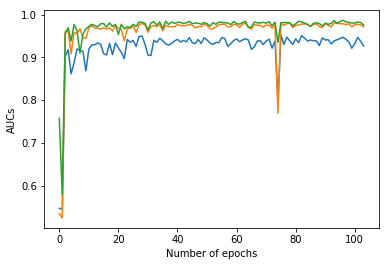

In [66]:
plt.plot(auc_history['split0_123'])
plt.plot(auc_history['split01_23'])
plt.plot(auc_history['split012_3'])
plt.xlabel('Number of epochs')
plt.ylabel('AUCs')

In [88]:
tst_df = pd.read_csv(path+'tst_labels.csv')
tst_df = tst_df.reset_index(drop=True)

In [50]:
validation_gen = ImageFrameGenerator()

In [98]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1667 images to generate mini-batches.


In [52]:
model.load_weights(model_path+'binary3_auc_1111.h5')

In [53]:
y = model.predict_generator(tst_itr, verbose=1)

53/53 [==============================] - 24s 458ms/step


In [54]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [55]:
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

In [56]:
y_pred.shape, y_true.shape

((1667, 3), (1667, 3))

{0: 0.8703516110533775, 1: 0.9198552348403632, 2: 0.9231211656441717}

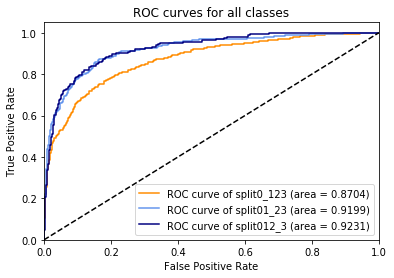

In [57]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [46]:
y_pred

array([[5.99314153e-01, 2.28909478e-02, 1.07496395e-03],
       [8.61447155e-01, 1.06399626e-01, 3.75232834e-04],
       [9.84677792e-01, 5.70016980e-01, 1.62384529e-02],
       ...,
       [5.58475222e-05, 1.10411385e-07, 1.36902200e-11],
       [1.45818262e-06, 2.15458140e-09, 2.50117960e-13],
       [1.26331742e-03, 9.31455659e-08, 8.23103807e-11]], dtype=float32)

In [103]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

In [48]:
score4[:, 0] = 1 - y_pred[:, 0]
for j in range(1, score4.shape[1]-1):
    score4[:, j] = y_pred[:, j-1] - y_pred[:, j]
score4[:, -1] = y_pred[:, -1]

In [104]:
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

In [90]:
sum(score4<0)

array([0, 0, 0, 0])

In [105]:
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [106]:
mayo_true = tst_df.Mayo_score
mayo_true.name = 'Mayo_true'

In [107]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,771,73,2,0,846
1,139,216,26,5,386
2,7,36,61,34,138
3,1,7,28,112,148
All,918,332,117,151,1518


In [53]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.911348,0.085106,0.003546,0.000000
1,0.362694,0.551813,0.067358,0.018135
2,0.043478,0.260870,0.442029,0.253623
3,0.006757,0.047297,0.175676,0.770270


In [58]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.911348,0.086288,0.002364,0.000000
1,0.360104,0.559585,0.067358,0.012953
2,0.050725,0.260870,0.442029,0.246377
3,0.006757,0.047297,0.189189,0.756757


In [108]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear')

0.7396376450801716

In [109]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic')

0.8542864776064767

## Test on Video data

In [8]:
vfilenames = os.listdir(path+'all_video_images/')

In [9]:
vfilenames = set(vfilenames)

In [10]:
video_labels = pd.read_excel(path+'VideoTestSet_labels_27MAY2018.xlsx')

In [119]:
video_labels.columns

Index(['ID', 'basefile', 'pathname', 'file_seq', 'SubjectID', 'Mayo_0',
       'Mayo_1', 'Mayo_2', 'Mayo_3'],
      dtype='object')

In [11]:
video_labels['filename'] = [s+b for s, b in zip(video_labels.SubjectID, video_labels.basefile)]

In [12]:
video_labels = video_labels.loc[video_labels.filename.isin(vfilenames)]

In [13]:
subjects = '001 007 008 010 037 045 046 052 057 060 061 Lycera_001 Lycera_002 Lycera_003 Lycera_005 Lycera_006 079 088 089 091 093 096'.split()

In [14]:
video_labels = video_labels.loc[video_labels.SubjectID.isin(subjects)]

In [15]:
len(video_labels.SubjectID.value_counts())

22

In [16]:
video_labels = video_labels.loc[video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].apply(sum, axis=1)==1]

In [17]:
video_labels = video_labels.dropna(subset=['filename', 'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

In [18]:
video_labels['split0_123'] = (~video_labels.Mayo_0).astype(int)
video_labels['split01_23'] = (video_labels.Mayo_2 | video_labels.Mayo_3).astype(int)
video_labels['split012_3'] = video_labels.Mayo_3.astype(int)

In [19]:
video_labels['Mayo_score'] = 0
video_labels.loc[video_labels.Mayo_1, 'Mayo_score'] = 1
video_labels.loc[video_labels.Mayo_2, 'Mayo_score'] = 2
video_labels.loc[video_labels.Mayo_3, 'Mayo_score'] = 3

In [20]:
video_labels.Mayo_score.value_counts()

0    5605
1     977
2     659
3     256
Name: Mayo_score, dtype: int64

In [21]:
video_labels.shape

(7497, 14)

In [22]:
video_labels.to_csv(path+'video_labels.csv', index=False)

### Prediction by 3 binary model

In [47]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'all_video_images/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 15072 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7497 images to generate mini-batches.


In [48]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [73]:
model.load_weights(model_path+'binary3_valloss_0528.h5')

In [74]:
y = model.predict_generator(tst_itr, verbose=1)

235/235 [==============================] - 208s 884ms/step


In [75]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [76]:
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

In [53]:
y_pred.shape, y_true.shape

((7497, 3), (7497, 3))

{0: 0.9630059803897532, 1: 0.9805663068511073, 2: 0.9941527629125811}

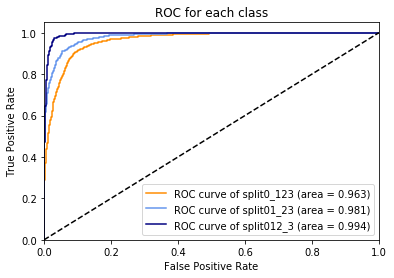

In [77]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [68]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

In [69]:
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

In [70]:
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [58]:
mayo_true = video_labels.Mayo_score.reset_index(drop=True)
mayo_true.name = 'Mayo_true'

In [66]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,5038,490,48,29,5605
1,140,711,115,11,977
2,20,123,434,82,659
3,0,1,19,236,256
All,5198,1325,616,358,7497


In [67]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.898840,0.087422,0.008564,0.005174
1,0.143296,0.727738,0.117707,0.011259
2,0.030349,0.186646,0.658574,0.124431
3,0.000000,0.003906,0.074219,0.921875


In [71]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear')

0.7274866302283287

In [72]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic')

0.8118400398385246

## Cross Validation

### Splitting for 10-fold cross validation

In [64]:
from sklearn.model_selection import GroupKFold

In [58]:
train_df = pd.read_csv(path+'train_labels.csv')
tst_df = pd.read_csv(path+'tst_labels.csv')

In [59]:
all_df = pd.concat([train_df, tst_df])

In [60]:
all_df = all_df.reset_index(drop=True)

In [63]:
all_df.shape, len(all_df.SourceReportName.value_counts())

((16514, 10), 3082)

In [67]:
split = GroupKFold(n_splits=10)

In [68]:
fold = 0
for train_ind, tst_ind in split.split(all_df, groups=all_df.SourceReportName):
    train_df = all_df.loc[train_ind]
    tst_df = all_df.loc[tst_ind]
    train_df.to_csv(path+'CV_adjudication/train_labels'+str(fold)+'.csv', index=False)
    tst_df.to_csv(path+'CV_adjudication/tst_labels'+str(fold)+'.csv', index=False)
    fold += 1

In [69]:
patient_sets = []
for j in range(10):
    df = pd.read_csv(path+'CV_adjudication/tst_labels'+str(j)+'.csv')
    patient_sets.append(set(df.SourceReportName))

In [70]:
[len(s) for s in patient_sets]

[308, 308, 309, 309, 308, 308, 308, 308, 308, 308]

In [75]:
for ps in patient_sets:
    print(len(patient_sets[7].intersection(ps)))

0
0
0
0
0
0
0
308
0
0


### Summary of Results

In [10]:
from sklearn.metrics import roc_curve, auc

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [12]:
validation_gen = ImageFrameGenerator()

In [27]:
thresh = 0.5
auc01_23 = []
sensi01_23 = []
speci01_23 = []
ppv01_23 = []
npv01_23 = []
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []

In [28]:
for cv in range(10):
    tst_df = pd.read_csv(path+'CV_adjudication/tst_labels'+str(cv)+'.csv')
    tst_df = tst_df.reset_index(drop=True)
    tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)
    model.load_weights(model_path+'CV_adjudication/binary3_auc'+str(cv)+'1.h5')
    y = model.predict_generator(tst_itr, verbose=1)

    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    auc01_23.append(auc(fpr, tpr))
    
    sensi01_23.append(sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
    speci01_23.append(sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
    ppv01_23.append(sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_pred[:, 1]>thresh))
    npv01_23.append(sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_pred[:, 1]<thresh))
    
    score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
    score4[:, 0] = 1 - y_pred[:, 0]
    score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
    score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
    score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

    mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
    mayo_true = tst_df.adj_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic'))

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 459ms/step
Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 456ms/step
Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.
52/52 [==============================] - 24s 457ms/step
Foun

In [25]:
import statsmodels.stats.api as sms

In [29]:
np.savez('output/CV_adjudication_avg3.npz', auc01_23=auc01_23, sensi01_23=sensi01_23, speci01_23=speci01_23, ppv01_23=ppv01_23, 
         npv01_23=npv01_23, acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, kappa_l=kappa_linear, kappa_q=kappa_quad)

In [70]:
load = np.load('output/CV_adjudication_avg3.npz')

In [84]:
x = 'kappa_l'
print('{0:.4f}'.format(np.mean(load[x])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[x]).tconfint_mean()))

0.7421
(0.7271, 0.7571)


In [82]:
x = 'acc3'
print('{0:.4f}'.format(np.mean(load[x])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[x]).tconfint_mean()))

0.6779
(0.6491, 0.7067)


### Single result

In [33]:
tst_seed = 0

In [34]:
tst_df = pd.read_csv(path+'CV_adjudication/tst_labels{}.csv'.format(tst_seed))
tst_df = tst_df.reset_index(drop=True)
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1652 images to generate mini-batches.


In [60]:
ys = []
for val_seed in range(1, 4):
    model.load_weights(model_path+'CV_adjudication/binary3_auc{}{}.h5'.format(tst_seed, val_seed))
    ys.append(model.predict_generator(tst_itr, verbose=1))

52/52 [==============================] - 24s 456ms/step


In [61]:
y_preds = []
for y in ys:
    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [62]:
y_pred_avg = np.mean(np.stack(y_preds, axis=0), axis=0)

In [67]:
score4 = np.zeros((y_pred_avg.shape[0], y_pred_avg.shape[1]+1), dtype=float)
score4[:, 0] = 1 - y_pred_avg[:, 0]
score4[:, 1] = y_pred_avg[:, 0]*(1-y_pred_avg[:,1])
score4[:, 2] = y_pred_avg[:, 0]*y_pred_avg[:,1]*(1-y_pred_avg[:,2])
score4[:, 3] = y_pred_avg[:, 0]*y_pred_avg[:,1]*y_pred_avg[:,2]
mayo_pred_avg = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [63]:
mayo_true = tst_df.adj_score
mayo_true.name = 'Mayo_true'
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values
rev1 = [1-sum((tst_df.Mayo_Rev1_Corrected<=1) & (tst_df.adj_score<=1))/sum(tst_df.adj_score<=1), 
        sum((tst_df.Mayo_Rev1_Corrected>=2) & (tst_df.adj_score>=2))/sum(tst_df.adj_score>=2)]
rev2 = [1-sum((tst_df.Mayo_Rev2_Corrected<=1) & (tst_df.adj_score<=1))/sum(tst_df.adj_score<=1), 
        sum((tst_df.Mayo_Rev2_Corrected>=2) & (tst_df.adj_score>=2))/sum(tst_df.adj_score>=2)]

In [68]:
(cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(mayo_pred_avg.values, mayo_true.values, weights='quadratic'))

(0.7755715659548638, 0.8673212175810292)

In [57]:
(cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, mayo_true.values, weights='quadratic'))

(0.8899027893117093, 0.9411746896552199)

In [58]:
(cohen_kappa_score(tst_df.Mayo_Rev2_Corrected.values, mayo_true.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev2_Corrected.values, mayo_true.values, weights='quadratic'))

(0.8038311539193794, 0.8861769149891277)

In [59]:
(cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, tst_df.Mayo_Rev2_Corrected.values, weights='linear'), 
 cohen_kappa_score(tst_df.Mayo_Rev1_Corrected.values, tst_df.Mayo_Rev2_Corrected.values, weights='quadratic'))

(0.723538697237605, 0.8548372282259987)

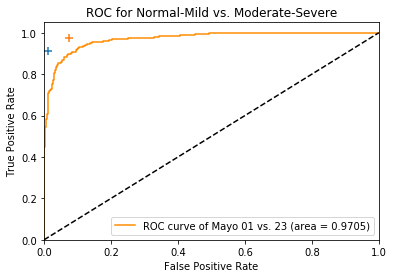

In [73]:
plot_roc(y_pred_avg[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', 
         savefile = 'output/roc01_23.tiff')
plt.scatter(*rev1, marker='+', s=50)
plt.scatter(*rev2, marker='+', s=50)

In [39]:
rev1, rev2

([0.01146601146601145, 0.9118329466357309],
 [0.07371007371007376, 0.9721577726218097])

In [66]:
pd.crosstab(tst_df.Mayo_Rev1_Corrected, tst_df.adj_score, normalize='index')

Mayo_true,0,1,2,3
Mayo_Rev1_Corrected,,,,
0,0.946681,0.051143,0.002176,0.000000
1,0.150307,0.739264,0.110429,0.000000
2,0.007812,0.039062,0.832031,0.121094
3,0.006623,0.006623,0.033113,0.953642


In [22]:
thresh = 0.5
print('Threshold:', thresh)
print('Sensitivity', sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
print('Specificity', sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
print('PPV', sum((y_pred[:, 1]>thresh) & (y_true[:, 1]==1))/sum(y_pred[:, 1]>thresh))
print('NPV', sum((y_pred[:, 1]<thresh) & (y_true[:, 1]==0))/sum(y_pred[:, 1]<thresh))

Threshold: 0.5
Sensitivity 0.8677494199535963
Specificity 0.9516789516789517
PPV 0.8637413394919169
NPV 0.9532403609515997


In [23]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,821,85,14,2,922
1,103,156,34,6,299
2,17,39,179,21,256
3,1,2,43,129,175
All,942,282,270,158,1652


In [65]:
pd.crosstab(index=mayo_true, columns=mayo_pred_avg, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.895879,0.082430,0.019523,0.002169
1,0.301003,0.545151,0.137124,0.016722
2,0.050781,0.164062,0.699219,0.085938
3,0.005714,0.005714,0.245714,0.742857


### Cross Validation on Video Data

In [7]:
video_labels = pd.read_csv(path+'video_labels.csv')

In [8]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'all_video_images/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 15072 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7497 images to generate mini-batches.


In [38]:
auc01_23 = []
acc01 = []
acc23 = []
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []

In [ ]:
for cv in range(1, 11):
    model.load_weights(model_path+'cross_validation/binary3_valloss'+str(cv)+'.h5')
    y = model.predict_generator(tst_itr, verbose=1)

    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    auc01_23.append(auc(fpr, tpr))
    
    acc01.append(sum((y_pred[:, 1]<0.5) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
    acc23.append(sum((y_pred[:, 1]>0.5) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
    
    score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
    score4[:, 0] = 1 - y_pred[:, 0]
    score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
    score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
    score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

    mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
    mayo_true = video_df.Mayo_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic'))

221/235 [===========================>..] - ETA: 28s

In [9]:
import statsmodels.stats.api as sms

In [38]:
np.savez('output/cv_video.npz', auc01_23=auc01_23, acc01=acc01, acc23=acc23, acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, 
         kappa_l=kappa_linear, kappa_q=kappa_quad)

In [11]:
load = np.load('output/cv_video.csv.npz')

In [26]:
quant = 'kappa_q'
print('{0:.4f}'.format(np.mean(load[quant])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[quant]).tconfint_mean()))

0.8208
(0.8030, 0.8386)


In [27]:
load['kappa_q']

array([0.84936455, 0.78959016, 0.82597789, 0.80483156, 0.81998876,
       0.80572939, 0.82666238, 0.85805186, 0.78418327, 0.84335693])

In [31]:
model.load_weights(model_path+'cross_validation/binary3_valloss8.h5')
y = model.predict_generator(tst_itr, verbose=1)

235/235 [==============================] - 257s 1s/step


In [34]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values
    
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
mayo_true = video_labels.Mayo_score
mayo_true.name = 'Mayo_true'

{0: 0.9789437329494416}

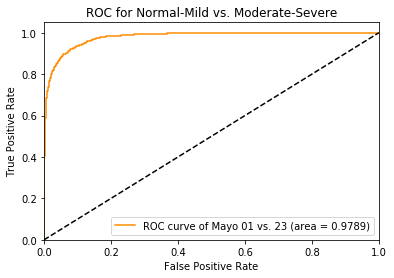

In [35]:
plot_roc(y_pred[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', 
         savefile = 'output/roc01_23_video.tiff')

In [36]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,5197,380,24,4,5605
1,252,683,39,3,977
2,16,226,396,21,659
3,0,11,70,175,256
All,5465,1300,529,203,7497


In [37]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.927208,0.067797,0.004282,0.000714
1,0.257932,0.699079,0.039918,0.003071
2,0.024279,0.342944,0.600910,0.031866
3,0.000000,0.042969,0.273438,0.683594
